## ReLU-DAE (CelebA)
This notebook reproduces **Figures 4-5**:

1. Load CelebA.
2. Train a ReLU-DAE (pretrained weights provided).
3. Visualize learned weights and representations.


## Load data

/Users/zhangzekai/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


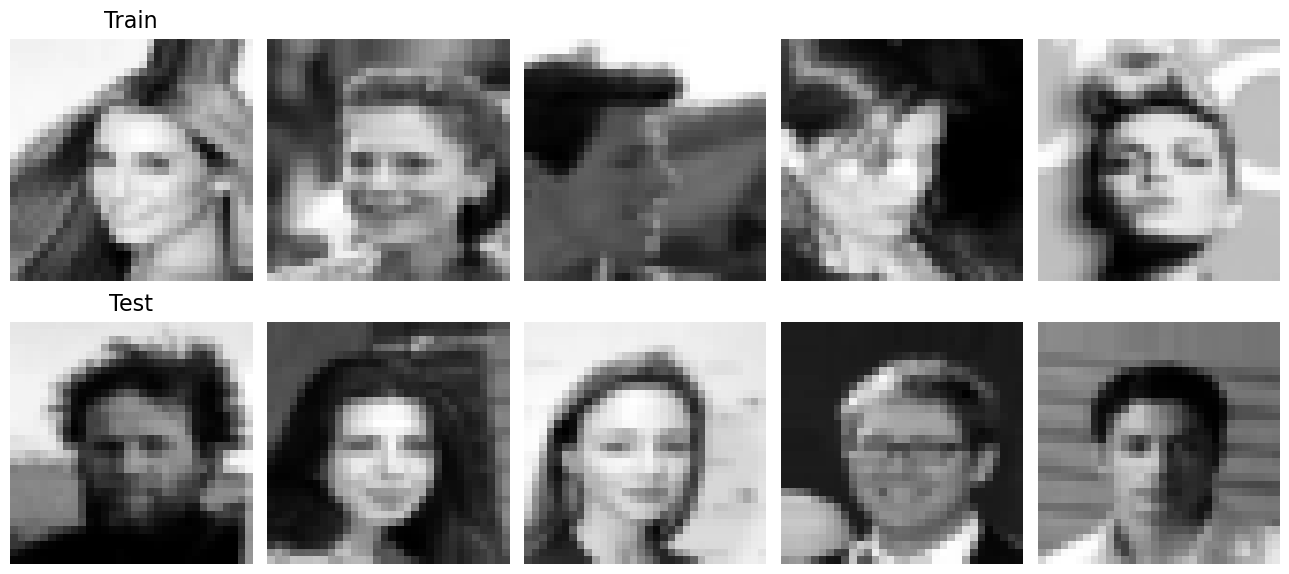

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from datasets import load_dataset

os.makedirs("../Figs", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# CelebA (32×32 grayscale), streamed from HuggingFace
N_train, N_test = 10_000, 20
tfm = T.Compose([
    T.Resize((32, 32)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),  # [0,1]
])

ds = load_dataset("eurecom-ds/celeba", split="train", streaming=True)
it = iter(ds)
trainset = torch.stack([tfm(next(it)["image"]) for _ in range(N_train)])
testset  = torch.stack([tfm(next(it)["image"]) for _ in range(N_test)])

# quick sanity check
fig, axes = plt.subplots(2, 5, figsize=(13, 6))
for i in range(5):
    axes[0, i].imshow(trainset[i, 0].numpy(), cmap="gray"); axes[0, i].axis("off")
    axes[1, i].imshow(testset[i, 0].numpy(),  cmap="gray"); axes[1, i].axis("off")
axes[0, 0].set_title("Train", fontsize=16, pad=8)
axes[1, 0].set_title("Test",  fontsize=16, pad=8)
plt.tight_layout()
plt.show()


### ReLU-DAE model

In [2]:
# DAE model
class DAE(torch.nn.Module):
    def __init__(self, d=100):
        super(DAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(32 * 32, d, bias=False),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(d, 32 * 32, bias=False),
        )
        # comment to disable weight tying
        self.decoder[0].weight = torch.nn.Parameter(self.encoder[0].weight.t()) 

    def forward(self, x):
        latent = self.encoder(x)
        latent = torch.nn.functional.relu(latent)
        x = self.decoder(latent)
        return x


### Train a memorized model (5 samples)


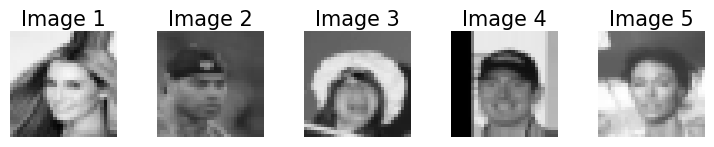

In [3]:
############### Select 5 images for training Mem. DAE ###################
##### Hint: the images are selected for strong separability, try different idxs #####
idxs = [0, 36, 148, 195, 232]
img_mem = trainset[idxs] * 2 - 1                                  # -> [-1,1]
flat_mem = img_mem.view(len(idxs), -1)                            # (5,1024) if you need flattened

# visualize
plt.figure(figsize=(1.5 * 5, 1.5))
for i in range(len(idxs)):
    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(img_mem[i, 0].cpu().numpy(), cmap="gray", vmin=-1, vmax=1)
    ax.set_title(f"Image {i+1}", fontsize=15, pad=4)
    ax.axis("off")
plt.tight_layout()
plt.show()


# ################### Training (uncomment to train your model) ###################
# sigma = 0.2
# torch.manual_seed(1)
# model_mem = DAE()
# ##### Hint: try different optimizers, lr, weight_decay #####
# optimizer = torch.optim.RMSprop(model_mem.parameters(), lr=0.001, weight_decay=0.01)
# # optimizer = torch.optim.Adam(model_mem.parameters(), lr=0.001, weight_decay=0.01)
# # optimizer = torch.optim.AdamW(model_mem.parameters(), lr=0.001, weight_decay=0.01)
# # optimizer = torch.optim.SGD(model_mem.parameters(), lr=0.001, weight_decay=0.01)

# criterion = torch.nn.MSELoss()
# epochs = 50000
# for epoch in range(epochs):
#     optimizer.zero_grad()
#     # Add noise to the image
#     noisy_img = flat_mem + sigma * torch.randn_like(flat_mem)
#     output = model_mem(noisy_img)
#     loss = criterion(output, flat_mem)
#     loss.backward()
#     optimizer.step()
#     if epoch % 5000 == 0:
#         print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

# torch.save(model_mem.state_dict(), 'checkpoints/DAE_sample_5_sigma_0.2.pth')


### Train a generalized model (10,000 samples)


In [ ]:
############### Select N images for training Gen. DAE ###################
img_gen = trainset * 2 - 1                                # -> [-1,1]
flat_gen = img_gen.view(N_train, -1)                                # (N,1024)


# ################### Training (uncomment to train your model) ###################
# sigma = 0.2
# torch.manual_seed(1)
# model_gen = DAE()

# ##### Hint: try different optimizers, lr, weight_decay #####
# # optimizer = torch.optim.RMSprop(model_gen.parameters(), lr=0.0001, weight_decay=0.0001)
# optimizer = torch.optim.Adam(model_gen.parameters(), lr=0.0001, weight_decay=0.0001)
# # optimizer = torch.optim.AdamW(model_gen.parameters(), lr=0.0001, weight_decay=0.0001)
# # optimizer = torch.optim.SGD(model_gen.parameters(), lr=0.0001, weight_decay=0.0001)

# criterion = torch.nn.MSELoss()
# epochs = 50000
# for epoch in range(epochs):
#     optimizer.zero_grad()
#     # Sample a minibatch
#     idx = torch.randint(0, N_train, (256,)) # batch size 256
#     clean = flat_gen[idx]
#     noisy = clean + sigma * torch.randn_like(clean)
#     output = model_gen(noisy)
#     loss = criterion(output, clean)
#     loss.backward()
#     optimizer.step()
#     if epoch % 5000 == 0:
#         print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

# torch.save(model_gen.state_dict(), "checkpoints/DAE_sample_10000_sigma_0.2.pth")


### Figure 4: Learned weights (memorized vs generalized)


/var/folders/1h/5vgwqzz531v9hcsgfvmx_fnc0000gn/T/ipykernel_46663/2418878090.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 1])


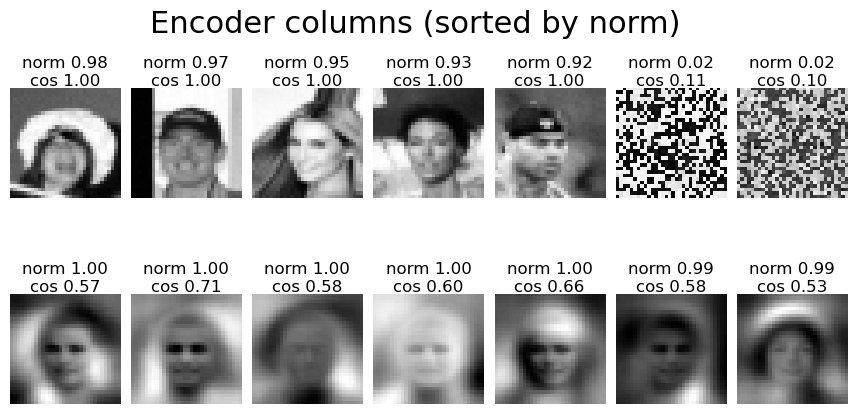

In [5]:
model_mem = DAE().eval()
model_mem.load_state_dict(torch.load("checkpoints/DAE_sample_5_sigma_0.2.pth", map_location="cpu"))
model_gen = DAE().eval()
model_gen.load_state_dict(torch.load("checkpoints/DAE_sample_10000_sigma_0.2.pth", map_location="cpu"))

img_norm = flat_gen / torch.linalg.norm(flat_gen, dim=1, keepdim=True).clamp_min(1e-12)

Wm = model_mem.encoder[0].weight.detach().cpu()  # [H, D]
Wg = model_gen.encoder[0].weight.detach().cpu()
top_k = min(7, Wm.shape[0])

FIGSIZE = (10.8, 5.2)
SAVE_DPI = 300
fig, axes = plt.subplots(
    2, top_k,
    figsize=FIGSIZE,
    gridspec_kw={"hspace": 0.06, "wspace": 0.1}  # tighten gaps
)

for r, (W, name) in enumerate([(Wm, "Mem"), (Wg, "Gen")]):
    norms = torch.linalg.norm(W, dim=1)
    idxs = torch.argsort(norms, descending=True)[:top_k]
    for j, idx in enumerate(idxs):
        w = W[idx]
        max_cos = ((w @ img_norm.T) / w.norm().clamp_min(1e-12)).max().item()

        ax = axes[r, j]
        ax.imshow(w.view(32, 32).numpy(), cmap="gray")
        ax.set_title(f"norm {norms[idx]:.2f}\ncos {max_cos:.2f}", fontsize=12, pad=2)
        ax.set_xticks([]); ax.set_yticks([])
        ax.axis("off")

    axes[r, 0].set_ylabel(name, fontsize=18, labelpad=10)

fig.suptitle("Encoder columns (sorted by norm)", fontsize=22, y=0.95)
fig.tight_layout(rect=[0, 0, 1, 1])

fig.savefig("../Figs/celeba_weights.png", dpi=SAVE_DPI)
plt.show()
plt.close(fig)

### Figure 5: Representations (memorized vs generalized)


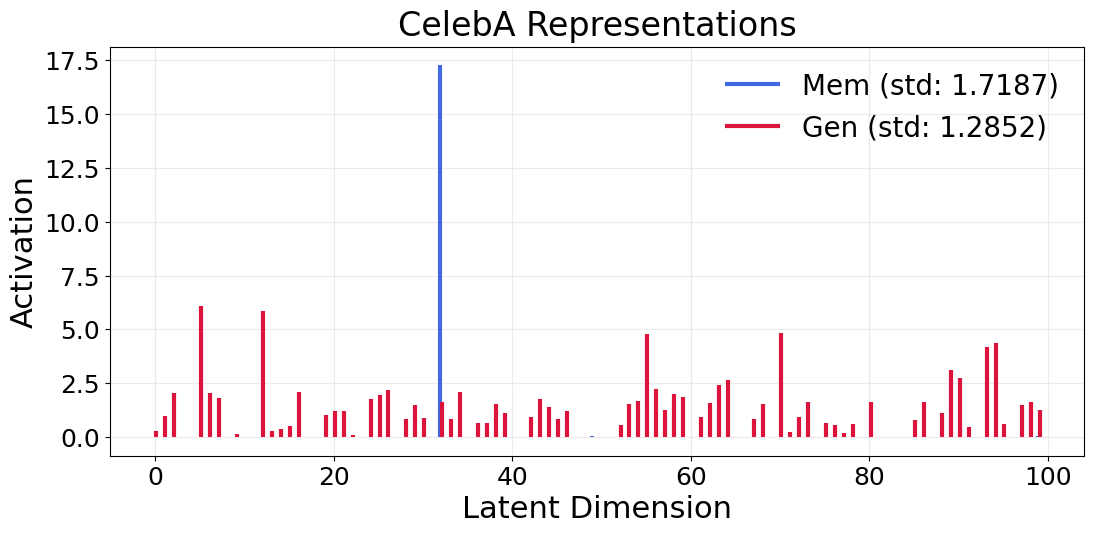

In [6]:
# Figure 5: Visualize representation differences (Mem vs Gen)
sigma = 0.2
with torch.no_grad():
    noisy = flat_mem[:5] + sigma * torch.randn_like(flat_mem[:5])
    rep_mem = torch.relu(model_mem.encoder(noisy))[0].cpu().numpy()
    rep_gen = torch.relu(model_gen.encoder(noisy))[0].cpu().numpy()

x = np.arange(rep_mem.size)


fig, ax = plt.subplots(figsize=FIGSIZE)
for y, dx, c, name in [(rep_mem, -0.12, "royalblue", "Mem"),
                       (rep_gen, +0.12, "crimson", "Gen")]:
    ax.vlines(x + dx, 0, y, lw=3, color=c, label=f"{name} (std: {y.std():.4f})")

ax.set_xlabel("Latent Dimension", fontsize=22)
ax.set_ylabel("Activation", fontsize=22)
ax.set_title("CelebA Representations", fontsize=24, pad=8)
ax.tick_params(axis="both", labelsize=18)
ax.legend(fontsize=20, loc="upper right", frameon=False)
ax.grid(True, alpha=0.25)

fig.tight_layout(pad=0.2)
fig.savefig("../Figs/celeba_rep.png", dpi=SAVE_DPI)
plt.show()
plt.close(fig)


### (Optional) Denoising results (memorized vs generalized)


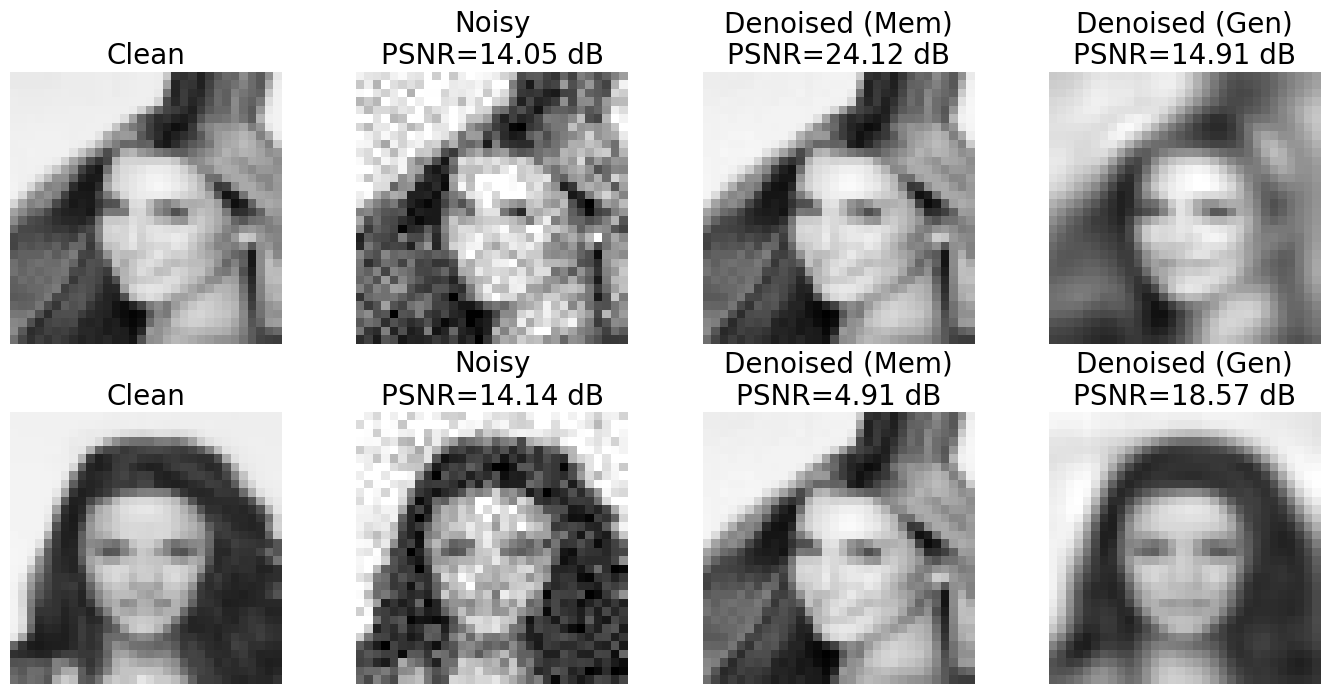

In [7]:
def psnr(a, b, peak=1.0, eps=1e-12):
    mse = (a - b).pow(2).mean().item()
    return 10 * np.log10((peak * peak) / (mse + eps))

sigma = 0.2
normalize_vis = True

# cached samples
clean_train = flat_gen[0].view(-1)
clean_test  = (testset[7] * 2 - 1).view(-1)

fig, axes = plt.subplots(2, 4, figsize=(14, 7))

with torch.no_grad():
    for r, (label, clean, seed) in enumerate([("Train", clean_train, 123), ("Test", clean_test, 456)]):
        torch.manual_seed(seed)
        noisy = clean + sigma * torch.randn_like(clean)

        den_m = model_mem(noisy[None]).squeeze(0)
        den_g = model_gen(noisy[None]).squeeze(0)

        den_m_vis, den_g_vis = den_m, den_g
        if normalize_vis:
            den_m_vis = den_m / den_m.detach().abs().max().clamp_min(1e-8)
            den_g_vis = den_g / den_g.detach().abs().max().clamp_min(1e-8)

        imgs = [clean, noisy, den_m_vis, den_g_vis]
        titles = [
            "Clean",
            f"Noisy\nPSNR={psnr(noisy, clean):.2f} dB",
            f"Denoised (Mem)\nPSNR={psnr(den_m, clean):.2f} dB",
            f"Denoised (Gen)\nPSNR={psnr(den_g, clean):.2f} dB",
        ]

        for c, (img, t) in enumerate(zip(imgs, titles)):
            ax = axes[r, c]
            ax.imshow(img.detach().cpu().view(32, 32), cmap="gray", vmin=-1, vmax=1)
            ax.set_title(t, fontsize=20, pad=6)
            ax.axis("off")

        axes[r, 0].set_ylabel(label, fontsize=25, labelpad=14)

plt.tight_layout()
plt.savefig("../Figs/celeba_denoise.png", dpi=200)
plt.show()
